<H2><CENTER> Sentiment Analysis<CENTER><H2>

### Importing necessary packages

In [1]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from cltk.stop.classical_hindi.stops import STOPS_LIST

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

### Reading files

In [4]:
import codecs
with codecs.open('bengali_data.txt', encoding='utf-8') as f:
    txt = f.read()#to read the total file
print(txt[0:1000])

আমি জানি এই জীবনটারঙীন!তাইবলেএমনরঙে জীবনটাকে রাঙিয়ে তুলুন না,যাতে করেপরো জীবন এ আপনাররঙের সাথী হয় জাহান্নামে লালআগুন একটু হলেও ভাবুন
আমি নির্বাক #MASH বস হেডস অফ টু ইউ কাপালি দ্যা হিউম্যান যাকে আইসিএল এ আমরা বিস্ফোরক হতে দেখেছি এবং তারই একটা শোডাউন #CHAMP
একটি ডায়গনিস্টিক বা মলত্যাগ: ((;´☋｀;)):ঈশ্বরের ডায়গনিস্টিক বা: ((;´☋｀;)):আমি বিষ্ঠা নির্ণয়েররররররররররーーーーーーーーーー！！！！！！！！
জিনঁ আমি আপনি ভালবাসেন এবং আপনি আমাকে হত্যা প্রেম .. مجرد نصيحه وكل واحد حر بنفسه — . …
#ঠিক_এমন_এভাবে #তুই_থেকে_যা_স্বভাবে #আমি_বুঝেছি_কদিনেই #আর_তুই_ছাড়া_গতি_নেই
যখন থাকো কাছে উষ্ণ প্রেমের আঁচে হয়ে যাই ঘুড়ী এক সাথে উড়ি, যখন যাও দূরে মনটা হয় ভবঘুরে আমি আর এ হৃদয় একসাথে পুড়ি......
আমি চেষ্টা করবো তিন জায়গায় ভালো করার যেহেতু আমি বোলিংও করতে পারি ব্যাটসম্যান আছি ফিল্ডারও আছি মূল কথা হচ্ছে শতভাগ দেয়ার চেষ্টা করবো.
বালিকা,, তুমি লাইটার হয়ে যাও;) আমি,, বিড়িটা একটু ধরাই বিড়ি টানতে মন চাইতাছে
#In_a_relationship এর বাংলা অনুবাদ: আমি জেনেশুনে আগুনে ঝাপ দিলাম! -_--_-
দিনশেষে এইটাই প্রাপ্তি... যে, আমি কে?? তুম

In [7]:

sentiment=(pd.read_csv("bengali_data.csv"))
sentiment= sentiment["label"].tolist() 

### Cleaning Text

In [8]:
def remove_punct(text):
    new_words = " "
    for word in text:
        w = re.sub(r'[.#-:?!\_|""'',-...A-Za-z0-9]','',word) #remove everything except words and space#how 
        new_words = new_words + w
    return re.sub(r"\s+", " ", new_words, flags=re.UNICODE)

In [9]:
text=txt.splitlines()
#print(remove_punct(text_cleaned[0:10000]))
filtered_sentence = []
for i in range(0,len(text)):
    filtered_sentence.append(remove_punct(text[i]))
print(filtered_sentence[0:10])

[' আমি জানি এই জীবনটারঙীনতাইবলেএমনরঙে জীবনটাকে রাঙিয়ে তুলুন নাযাতে করেপরো জীবন এ আপনাররঙের সাথী হয় জাহান্নামে লালআগুন একটু হলেও ভাবুন', ' আমি নির্বাক বস হেডস অফ টু ইউ কাপালি দ্যা হিউম্যান যাকে আইসিএল এ আমরা বিস্ফোরক হতে দেখেছি এবং তারই একটা শোডাউন ', ' একটি ডায়গনিস্টিক বা মলত্যাগ ;´☋｀;ঈশ্বরের ডায়গনিস্টিক বা ;´☋｀;আমি বিষ্ঠা নির্ণয়েররররররররররーーーーーーーーーー！！！！！！！！', ' জিনঁ আমি আপনি ভালবাসেন এবং আপনি আমাকে হত্যা প্রেম مجرد نصيحه وكل واحد حر بنفسه — …', ' ঠিকএমনএভাবে তুইথেকেযাস্বভাবে আমিবুঝেছিকদিনেই আরতুইছাড়াগতিনেই', ' যখন থাকো কাছে উষ্ণ প্রেমের আঁচে হয়ে যাই ঘুড়ী এক সাথে উড়ি যখন যাও দূরে মনটা হয় ভবঘুরে আমি আর এ হৃদয় একসাথে পুড়ি', ' আমি চেষ্টা করবো তিন জায়গায় ভালো করার যেহেতু আমি বোলিংও করতে পারি ব্যাটসম্যান আছি ফিল্ডারও আছি মূল কথা হচ্ছে শতভাগ দেয়ার চেষ্টা করবো', ' বালিকা তুমি লাইটার হয়ে যাও; আমি বিড়িটা একটু ধরাই বিড়ি টানতে মন চাইতাছে', ' এর বাংলা অনুবাদ আমি জেনেশুনে আগুনে ঝাপ দিলাম ', ' দিনশেষে এইটাই প্রাপ্তি যে আমি কে তুমি কার আমি নীড় তুমি ফায়ার']


### text to vector

In [10]:
tokens = Tokenizer(num_words = np.inf,oov_token = "<OOV>")
tokens.fit_on_texts(filtered_sentence)
word_index = tokens.word_index


In [11]:
sequences = tokens.texts_to_sequences(filtered_sentence)
pad = pad_sequences(sequences,padding = 'post')

In [12]:
le = LabelEncoder()
Y = le.fit_transform(sentiment[0:len(filtered_sentence)])
la=le.inverse_transform(Y)
set(la)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19}

### Splitting data

In [13]:
#Splitting the data into train data and test data
X_train, X_test, y_train, y_test = train_test_split(pad,Y, test_size = 0.15, random_state = 42)

In [14]:
#Printing the size of the train data, train label, test data and test label
print("Shape train data = ",np.shape(X_train))
print("Shape of train label = ",np.shape(y_train))
print("Shape of test data = ",np.shape(X_test))
print("Shape of test label = ",np.shape(y_test))

Shape train data =  (50598, 51)
Shape of train label =  (50598,)
Shape of test data =  (8930, 51)
Shape of test label =  (8930,)


### Classification Algorithm

#### Decision Tree Classifier

In [15]:
clf1 = DecisionTreeClassifier()
clf1 = clf1.fit(X_train, y_train)

In [16]:
y_pred = clf1.predict(X_test)

#### Decision Tree Classifier Report

In [17]:
#Computation of the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ','%.2f'%(accuracy*100))

Accuracy =  66.30


In [18]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report1 = classification_report(y_test, y_pred)

macro_precision1 =  report['macro avg']['precision'] 
macro_recall1 = report['macro avg']['recall']    
macro_f11 = report['macro avg']['f1-score']
accuracy1 = report['accuracy']

print(report1)

              precision    recall  f1-score   support

           0       0.61      0.62      0.61       510
           1       0.64      0.63      0.63       803
           2       0.69      0.71      0.70      1385
           3       0.56      0.60      0.58       125
           4       0.60      0.51      0.55        61
           5       0.69      0.68      0.69      1249
           6       0.67      0.68      0.67       922
           7       0.60      0.56      0.57        45
           8       0.50      0.53      0.52       100
           9       0.55      0.57      0.56       322
          10       0.66      0.71      0.68        80
          11       0.85      0.84      0.85       398
          12       0.62      0.62      0.62       636
          13       0.65      0.61      0.63       541
          14       0.56      0.51      0.53        55
          15       0.67      0.64      0.65       776
          16       0.00      0.00      0.00         4
          17       0.50    

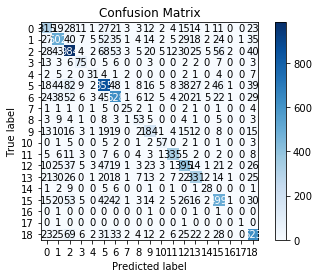

In [19]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


[519, 785, 1425, 135, 52, 1245, 940, 42, 105, 336, 87, 392, 633, 510, 50, 750, 8, 2, 914]


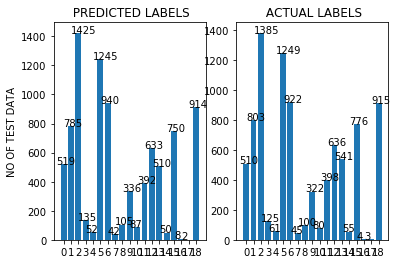

In [20]:
ax=plt.subplot(1,2,1)
x=np.arange(19)
height=[]
for i in range(0,19):
    height.append(len(y_pred[y_pred==i]))
print(height)
plt.bar(x, height=height)
plt.xticks(x, x)
plt.title(" PREDICTED LABELS")
plt.ylabel("NO OF TEST DATA")
for index, value in enumerate(x):
    
    plt.text(value-1,len(y_pred[y_pred==value]), str(len(y_pred[y_pred==value])))
height=[]
for i in range(0,19):
    height.append(len(y_test[y_test==i]))
plt.subplot(1,2,2)
plt.bar(x, height=height)
plt.xticks(x, x)
plt.title(" ACTUAL LABELS")
for index, value in enumerate(x):
    plt.text(value-1,len(y_test[y_test==value]) , str(len(y_test[y_test==value])))


#### Random forest Classifier

In [21]:
clf = RandomForestClassifier(max_depth=200, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
#Predict the class label for the test data using the trained model
y_pred = clf.predict(X_test)

#### Random forest Classifier Report

In [23]:
#Computation of the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ','%.2f'%(accuracy*100))

Accuracy =  67.46


In [24]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report1 = classification_report(y_test, y_pred)

macro_precision2 =  report['macro avg']['precision'] 
macro_recall2 = report['macro avg']['recall']    
macro_f12 = report['macro avg']['f1-score']
accuracy2 = report['accuracy']

print(report1)

              precision    recall  f1-score   support

           0       0.72      0.59      0.65       510
           1       0.79      0.63      0.70       803
           2       0.56      0.80      0.66      1385
           3       0.88      0.17      0.28       125
           4       0.82      0.51      0.63        61
           5       0.50      0.83      0.63      1249
           6       0.79      0.69      0.74       922
           7       0.81      0.49      0.61        45
           8       0.57      0.08      0.14       100
           9       0.74      0.43      0.54       322
          10       0.98      0.55      0.70        80
          11       0.82      0.81      0.82       398
          12       0.73      0.61      0.66       636
          13       0.86      0.58      0.70       541
          14       0.67      0.18      0.29        55
          15       0.87      0.65      0.74       776
          16       0.00      0.00      0.00         4
          17       0.00    

c:\users\kabilan n\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


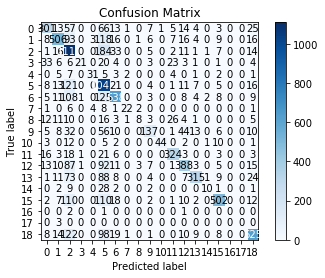

In [25]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


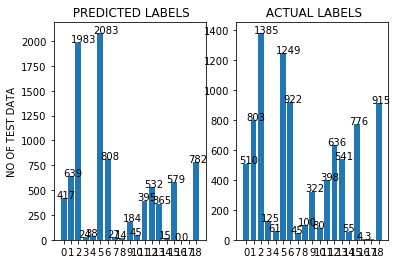

In [26]:
ax=plt.subplot(1,2,1)
x=np.arange(19)
height=[]
for i in range(0,19):
    height.append(len(y_pred[y_pred==i]))
plt.bar(x, height=height)
plt.xticks(x, x)
plt.title(" PREDICTED LABELS")
plt.ylabel("NO OF TEST DATA")
for index, value in enumerate(x):
    
    plt.text(value-1,len(y_pred[y_pred==value]), str(len(y_pred[y_pred==value])))
height=[]
for i in range(0,19):
    height.append(len(y_test[y_test==i]))
plt.subplot(1,2,2)
plt.bar(x, height=height)
plt.xticks(x, x)
plt.title(" ACTUAL LABELS")
for index, value in enumerate(x):
    plt.text(value-1,len(y_test[y_test==value]) , str(len(y_test[y_test==value])))


#### SVM

In [27]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
y_pred=clf.predict(X_test)

#### SVM Report

In [29]:
#Computation of the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ','%.2f'%(accuracy*100))

Accuracy =  34.24


In [30]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report1 = classification_report(y_test, y_pred)

macro_precision3 =  report['macro avg']['precision'] 
macro_recall3 = report['macro avg']['recall']    
macro_f13 = report['macro avg']['f1-score']
accuracy3 = report['accuracy']

print(report1)

              precision    recall  f1-score   support

           0       0.10      0.01      0.01       510
           1       0.57      0.47      0.52       803
           2       0.45      0.58      0.51      1385
           3       0.00      0.00      0.00       125
           4       0.00      0.00      0.00        61
           5       0.25      0.90      0.40      1249
           6       0.34      0.02      0.04       922
           7       0.00      0.00      0.00        45
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       322
          10       0.00      0.00      0.00        80
          11       0.44      0.22      0.30       398
          12       0.38      0.12      0.18       636
          13       0.19      0.01      0.02       541
          14       0.00      0.00      0.00        55
          15       0.31      0.10      0.15       776
          16       0.00      0.00      0.00         4
          17       0.00    

c:\users\kabilan n\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


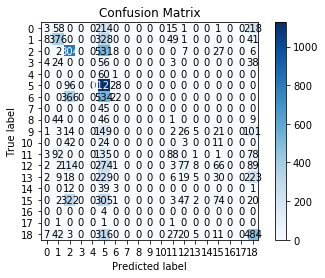

In [31]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


[30, 655, 1791, 0, 0, 4415, 64, 0, 0, 0, 0, 198, 201, 26, 0, 242, 0, 0, 1308]


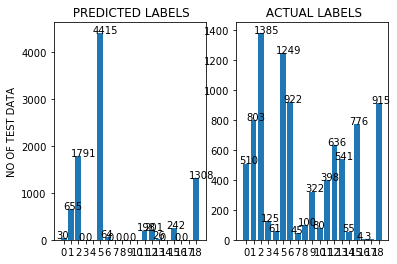

In [32]:
ax=plt.subplot(1,2,1)
x=np.arange(19)
height=[]
for i in range(0,19):
    height.append(len(y_pred[y_pred==i]))
print(height)
plt.bar(x, height=height)
plt.xticks(x, x)
plt.title(" PREDICTED LABELS")
plt.ylabel("NO OF TEST DATA")
for index, value in enumerate(x):
    
    plt.text(value-1,len(y_pred[y_pred==value]), str(len(y_pred[y_pred==value])))
height=[]
for i in range(0,19):
    height.append(len(y_test[y_test==i]))
plt.subplot(1,2,2)
plt.bar(x, height=height)
plt.xticks(x, x)
plt.title(" ACTUAL LABELS")
for index, value in enumerate(x):
    plt.text(value-1,len(y_test[y_test==value]) , str(len(y_test[y_test==value])))


#### Comparision

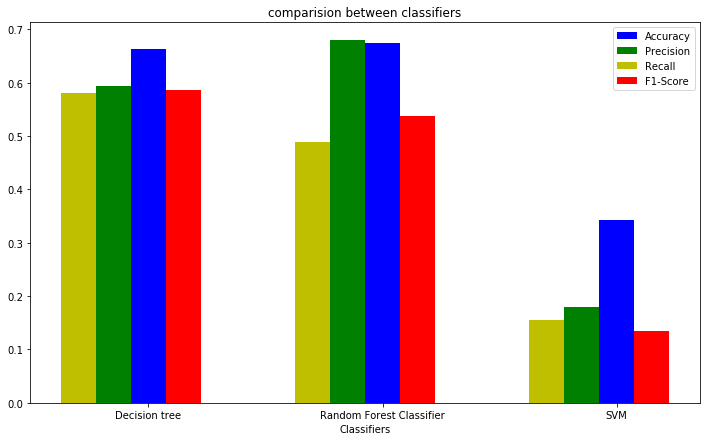

<Figure size 720x720 with 0 Axes>

In [37]:
a=np.arange(3)
w=0.15
fig,ax=plt.subplots(figsize=(12,7),edgecolor='k')
p1=ax.bar(a,[accuracy1,accuracy2,accuracy3],w,color='b')
p2=ax.bar(a-w,[macro_precision1,macro_precision2,macro_precision3],w,color='g')
p3=ax.bar(a-2*w,[macro_recall1,macro_recall2,macro_recall3],w,color='y')
p4=ax.bar(a+w,[macro_f11,macro_f12,macro_f13],w,color='r')
ax.set_xticks(a)
ax.set_xticklabels(('Decision tree','Random Forest Classifier','SVM'))
ax.set_title('comparision between classifiers')
ax.legend((p1[0],p2[0],p3[0],p4[0]),('Accuracy','Precision','Recall','F1-Score'))
plt.xlabel('Classifiers')
#plt.grid()
plt.figure(figsize=(10,10))
plt.show()

In [36]:
set(Y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}